In [2]:
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf
import uuid
from tensorflow.keras.metrics import Recall, Precision

In [11]:
!tar -xf lfw.tgz

In [13]:
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join("Data/Negative", file)
        os.replace(EX_PATH, NEW_PATH)

In [15]:
os.path.join("Data/Anchor", '{}.jpg'.format(uuid.uuid1()))

'Data/Anchor\\ab538fb7-ad0c-11ed-8309-93d2a3cd8eba.jpg'

In [5]:
cap = cv2.VideoCapture(0)
while cap.isOpened(): 
    ret, frame = cap.read()
   
    # Cut down frame to 250x250px
    frame = frame[120:120+250,200:200+250, :]
    
    # Collect anchors 
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # Create the unique file path 
        imgname = os.path.join("Data/Anchor", '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imgname, frame)
    
    # Collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        # Create the unique file path 
        imgname = os.path.join("Data/Positive", '{}.jpg'.format(uuid.uuid1()))
        # Write out positive image
        cv2.imwrite(imgname, frame)
    
    # Show image back to screen
    cv2.imshow('Image Collection', frame)
    
    # Breaking gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
        
# Release the webcam
cap.release()
# Close the image show frame
cv2.destroyAllWindows()

In [6]:
cap.release()

In [2]:
anchor = tf.data.Dataset.list_files("Data/Anchor"+'/*.jpg').take(350)
positive = tf.data.Dataset.list_files("Data/Positive"+'/*.jpg').take(350)
negative = tf.data.Dataset.list_files("Data/Negative"+'/*.jpg').take(350)

In [3]:
dir_test = anchor.as_numpy_iterator()

In [4]:
dir_test.next()

b'Data\\Anchor\\bbf64966-af8c-11ed-8173-c03eba3fdb08.jpg'

In [8]:
def preprocess(file_path):
    byte_img=tf.io.read_file(file_path)
    img=tf.io.decode_jpeg(byte_img)
    img=tf.image.resize(img,(100,100))
    img=img/255.0
    return img

In [6]:
img=preprocess("Data\\Anchor\\c0d3fa1e-af8c-11ed-90ce-c03eba3fdb08.jpg")

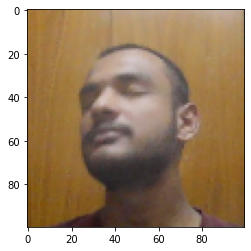

In [7]:
plt.imshow(img)

In [8]:
# (anchor, positive) => 1,1,1,1,1
# (anchor, negative) => 0,0,0,0,0

In [9]:
positives=tf.data.Dataset.zip((anchor,positive,tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives=tf.data.Dataset.zip((anchor,negative,tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data=positives.concatenate(negatives)

In [10]:
data

<ConcatenateDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [11]:
samples=data.as_numpy_iterator()

In [12]:
samples.next()

(b'Data\\Anchor\\b7925661-af8c-11ed-bc0c-c03eba3fdb08.jpg',
 b'Data\\Positive\\66ead87d-af8c-11ed-804b-c03eba3fdb08.jpg',
 1.0)

In [9]:
def preprocess_sec(input_img,validation_img,label):
    return (preprocess(input_img),preprocess(validation_img),label)

In [14]:
res=preprocess_sec(*samples.next())

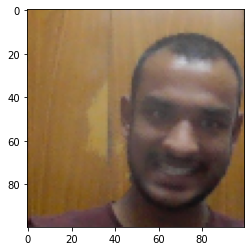

In [15]:
plt.imshow(res[1])

In [16]:
data=data.map(preprocess_sec)
data=data.cache()

In [17]:
data=data.shuffle(buffer_size=1024)

In [18]:
samples=data.as_numpy_iterator()

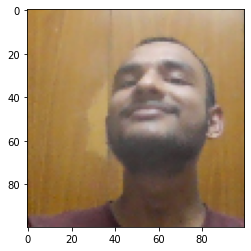

In [19]:
plt.imshow(samples.next()[1])

In [20]:
train_data=data.take(round(len(data)*0.7))
train_data=train_data.batch(16)
train_data=train_data.prefetch(8)

In [21]:
test_data=data.skip(round(len(data)*0.7)).take(round(len(data)*0.3))
test_data=test_data.batch(16)
test_data=test_data.prefetch(8)

In [22]:
data

<ShuffleDataset element_spec=(TensorSpec(shape=(100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [23]:
train_data

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

In [24]:
def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [25]:
embedding=make_embedding()

In [26]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 46, 46, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 17, 128)       26

In [3]:
class L1Dist(Layer):
    def __init__(self,**kwargs):
        super().__init__()
    
    def call(self,input_embedding,validation_embedding):
        return tf.math.abs(input_embedding-validation_embedding)

In [28]:
l1=L1Dist()

In [29]:
def make_siamese_model():
    input_img=Input(name='input_img',shape=(100,100,3))
    validation_img=Input(name='validation_img',shape=(100,100,3))
    siamese_layer=L1Dist()
    siamese_layer._name='distance'
    distances=siamese_layer(embedding(input_img),embedding(validation_img))
    classifier=Dense(1,activation='sigmoid')(distances)
    return Model(inputs=[input_img,validation_img],outputs=classifier,name='SiameseNetwork')

In [30]:
siamese_model=make_siamese_model()

In [31]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

In [32]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [33]:
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

In [36]:
checkpoint_dir='./training_checkpoints'
checkpoint_prefix=os.path.join(checkpoint_dir,'ckpt')
checkpoint=tf.train.Checkpoint(opt=opt,siamese_model=siamese_model)

In [52]:
@tf.function
def train_step(batch):
    with tf.GradientTape() as tape:
        x=batch[:2]
        y=batch[2]
        ypred=siamese_model(x,training=True)
        loss=binary_cross_loss(y,ypred)

    grad=tape.gradient(loss,siamese_model.trainable_variables)
    opt.apply_gradients(zip(grad,siamese_model.trainable_variables))
    
    return loss

In [53]:
def train(data,epochs):
    for epoch in range(1,epochs):
        print("\n Epoch ",epoch," of ",epochs)
        progbar=tf.keras.utils.Progbar(len(data))
        r=Recall()
        p=Precision()
        
        for idx,batch in enumerate(data):
            loss=train_step(batch)
            ypred=siamese_model(batch[:2])
            r.update_state(batch[2],ypred)
            p.update_state(batch[2],ypred)
            progbar.update(idx+1)
        print(loss.numpy(),r.result().numpy(),p.result().numpy())
        
        if epoch%10==0:
            checkpoint.save(file_prefix=checkpoint_prefix)

In [54]:
EPOCHS=50

In [55]:
train(train_data,EPOCHS)


 Epoch  1  of  50
31/31 [==============================] - 929s 30s/step
0.37274563 0.46530613 1.0

 Epoch  2  of  50
31/31 [==============================] - 935s 30s/step
0.11576299 0.9678715 1.0

 Epoch  3  of  50
31/31 [==============================] - 909s 29s/step
0.08471043 0.98380566 1.0

 Epoch  4  of  50
31/31 [==============================] - 2426s 80s/step
0.006725977 0.9876033 1.0

 Epoch  5  of  50
31/31 [==============================] - 896s 29s/step
0.019750869 0.9916318 1.0

 Epoch  6  of  50
31/31 [==============================] - 907s 29s/step
0.05466786 0.9958848 1.0

 Epoch  7  of  50
31/31 [==============================] - 974s 31s/step
0.06814502 1.0 1.0

 Epoch  8  of  50
31/31 [==============================] - 955s 31s/step
0.08001716 1.0 1.0

 Epoch  9  of  50
31/31 [==============================] - 946s 31s/step
0.01590809 0.9628099 0.99148935

 Epoch  10  of  50
31/31 [==============================] - 925s 30s/step
0.06302676 1.0 1.0

 Epoch  11  of

KeyboardInterrupt: 

In [57]:
test_input,test_val,ytrue=test_data.as_numpy_iterator().next()

In [58]:
ypred=siamese_model.predict([test_input,test_val])

1/1 [==============================] - 4s 4s/step


In [59]:
[1 if pred>0.5 else 0 for pred in ypred]

[1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0]

In [60]:
ytrue

array([1., 0., 1., 0., 0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1., 0.],
      dtype=float32)

In [62]:
r = Recall()
p = Precision()

for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = siamese_model.predict([test_input, test_val])
    r.update_state(y_true, yhat)
    p.update_state(y_true,yhat) 

print(r.result().numpy(), p.result().numpy())

1/1 [==============================] - 0s 413ms/step
1.0 1.0


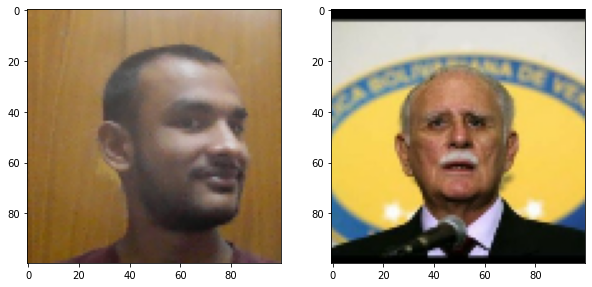

In [64]:
plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
plt.imshow(test_input[0])
plt.subplot(1,2,2)
plt.imshow(test_val[0])
plt.show()

In [65]:
siamese_model.save("siamesemodel.h5")

In [4]:
model=tf.keras.models.load_model("siamesemodel.h5",custom_objects={'L1Dist':L1Dist,'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [5]:
def verify(model,detection_threshold,verification_threshold):
    results=[]
    for image in os.listdir(os.path.join("Application_Data","Verification_Images")):
        input_image=preprocess(os.path.join("Application_Data","Input_Image","input_image.jpg"))
        verification_image=preprocess(os.path.join("Application_Data","Verification_Images",image))
        
        result=model.predict(list(np.expand_dims([input_image,verification_image],axis=1)))
        results.append(result)
        
    detection=np.sum(np.array(results)>detection_threshold)
    verification=detection/len(os.listdir(os.path.join("Application_Data","Verification_Images")))
    verified=verification>verification_threshold
    
    return results,verified

In [12]:
cap=cv2.VideoCapture(0)
while cap.isOpened():
    ret,frame=cap.read()
    frame=frame[120:120+250,200:200+250,:]
    cv2.imshow("Verification",frame)
    
    if cv2.waitKey(10) & 0xFF==ord('v'):
        cv2.imwrite(os.path.join("Application_Data","Input_Image","input_image.jpg"),frame)
        results,verified=verify(model,0.5,0.5)
        print(verified)
        
    if cv2.waitKey(10) & 0xFF==ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 362ms/step
True
1/1 [==============================] - 0s 375ms/step
False
1/1 [==============================] - 0s 283ms/step
False
1/1 [==============================] - 0s 291ms/step


1/1 [==============================] - 0s 299ms/step
True
1/1 [==============================] - 0s 291ms/step
True


In [11]:
cap.release()
cv2.destroyAllWindows()